## KNN with Nested Cross Validation from scratch

In this project we will present our own code that performs nested cross-validation and the k-nearest neighbour algorithm, build confusion matrices, and estimate distances between data samples.

## 1. Exploratory Data Analysis

In this project we are going to be working with the **Wine** dataset. This is a 178 sample dataset that categorises 3 different types of Italian wine using 13 different features. The code below loads the Wine dataset and selects a subset of features to work with. 

In [1]:
# set matplotlib backend to inline
%matplotlib inline 

# import modules
from sklearn import datasets 
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd

# load data
wine=datasets.load_wine()
#print(wine.DESCR)

# this dataset has 13 features, we will only choose a subset of these
df_wine = pd.DataFrame(wine.data, columns = wine.feature_names )
selected_features = ['alcohol','flavanoids','color_intensity','ash']

# extract the data as numpy arrays of features, X, and target, y
X = df_wine[selected_features].values
y = wine.target

### 1.1. Visualising the data

The first part of tackling any ML problem is visualising the data in order to understand some of the properties of the problem at hand.  When there are only a small number of classes and features, it is possible to use scatter plots to visualise interactions between different pairings of features. 

In [2]:
# define plotting function
import seaborn as sns
def myplotGrid(i,j):
    """Returns a pairplot of the data"""
    df = pd.DataFrame(i,columns = selected_features)
    df['target'] = j
    plot = sns.pairplot(df,
                        hue ='target',          # distinguishes classes by colors
                        vars=selected_features, # columns to plot
                        diag_kind= 'kde',       # uses density plots in the diagonal part
                        markers=["o", "s", "D"], 
                        palette = 'Set2')
    return plot

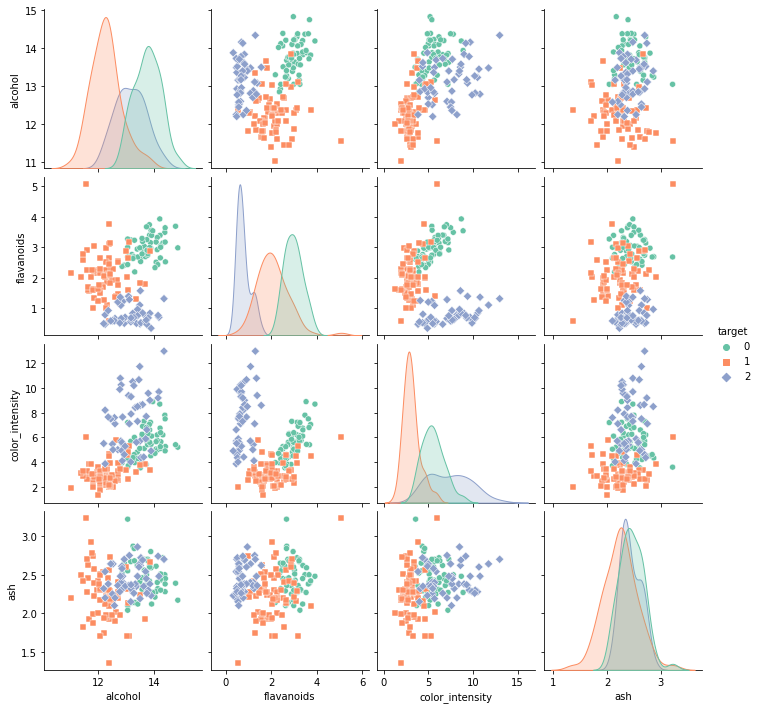

In [3]:
# run the plotting function
myplotGrid(X,y);

### 1.2. Exploratory Data Analysis under noise

When data are collected under real-world settings they usually contain some amount of noise that makes classification more challenging. In the cell below, we will invoke our exploratory data analysis function above on a noisy version of data X.

We will try to perturb the data with some Gaussian noise,

    # initialize random seed to replicate results over different runs
    mySeed = 12345 
    np.random.seed(mySeed) 
    XN=X+np.random.normal(0,0.5,X.shape)
    
and then invoke

    myplotGrid(XN,y)

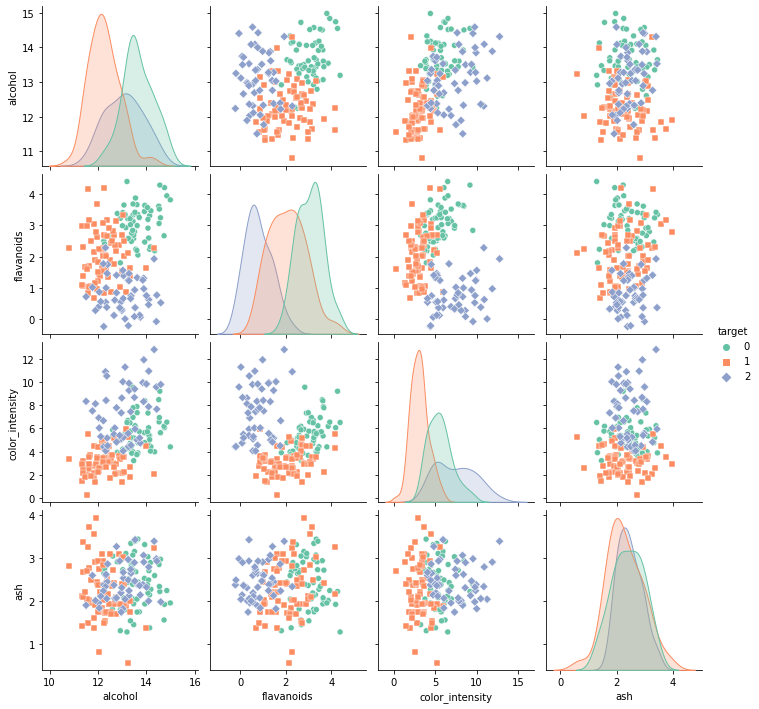

In [4]:
# noise code 
mySeed = 12345 
np.random.seed(mySeed) 
XN=X+np.random.normal(0,0.5,X.shape)
myplotGrid(XN,y);


###  Exploratory data analysis


Based on the exploratory analysis above, if we were to build a classifier using only two of the available features, the variables we would choose to build a classifier would be flavanoids and color_intensity. The reason behind this choice is that, if we analyse the plots above when these two variables are used, the distinction between the classes of the output variable seems to be more clear. The classes are well defined, and it is easier to distinguish them by eye.


### Data with noise

Adding some Gaussian noise to the data reduces the correlation between variables and makes classes in the plot less distinguishable from one another.

## 2. Implementing kNN

In the cell below, we will develop our own code for performing k-Nearest Neighbour classification.  We will use the scikit-learn k-NN implementation only as a way of verifying the results. Our implementation will not use any libraries other than the basic numpy and matplotlib functions. 

We will define a function that performs k-NN given a set of data.  The function will be invoked similary to:

        y_ = mykNN(X,y,X_,options)
        
where X is the training data, y is our training outputs, X\_ testing data and y\_  predicted outputs for X\_.  The options argument (can be a list or a set of separate arguments depending on how you choose to implement the function) will contain the number of neighbours to consider as well as the distance function employed.

Let's first start by representing the formulas of the distance metrics that are going to be used.

$$Euclidean Distance Formula$$
$$d(\mathbf {p,q})= \sqrt{\sum \limits_{i=1}^n (q_i-p_i)^2}$$  
$$Manhattan Distance Formula$$
$$d(\mathbf {p,q})= \sum \limits_{i=1}^n {|q_i-p_i|}$$

In [5]:
# helper code
# function for normalizing data
def min_max(X):
    """Finds mins and maxs and return normalized data"""
    mins = X.min(axis=(0), keepdims=True)
    maxs = X.max(axis=(0), keepdims=True)
    return (X-mins)/(maxs-mins)

X = min_max(X)
XN = min_max(XN)

# train test split function
def train_test_split(X, y, test_size):
    """Splits the dataset in train and test folds"""
    # get the number of train values depending on the number (from 0 to 1) assigned to the test_size parameter
    i = int((1 - test_size) * X.shape[0])
    # permutation shuffles the indicies of data values
    o = np.random.permutation(X.shape[0])
    # split the data using numpy
    X_train, X_test = np.split(np.take(X,o,axis=0), [i])
    y_train, y_test = np.split(np.take(y,o), [i])
    return X_train, X_test, y_train, y_test

X_train,X_test,y_train,y_test = train_test_split(X,y,0.3)


def mode(array):
    """Mode function, returns the most common value in an array 
        (used in the knn algorithm)"""
    vals,counts = np.unique(array, return_counts=True)
    index = np.argmax(counts)
    return (vals[index])


def euclidean(q,p):
    """Function for calculating Euclidean Distance based on the formula displayed above 
        (used in the knn algorithm)"""
    dist = np.sqrt(np.sum((q-p)**2))
    return dist


def manhattan(q,p):
    """Function for calculating Manhattan Distance based on the formula displayed above 
        (used in the knn algorithm)"""
    dist = np.sum(np.abs(q-p))
    return dist

In [6]:
# mykNN code 
def mykNN(x_train, y , x_input, k, dist_measure):
    """kNN algorithm. Predicts a value based on k neighbors"""
    output_labels = []
     
    #Loop through the Datapoints to be classified
    for item in x_input: 
         
        #Array to store distances
        point_dist = []
         
        #Loop through each training Data
        for j in range(len(x_train)): 
            distances = dist_measure(np.array(x_train[j,:]) , item) 
            #Calculating the distance
            point_dist.append(distances) 
        point_dist = np.array(point_dist) 
         
        #Sorting the array while preserving the index
        #Keeping the first K datapoints
        dist = np.argsort(point_dist)[:k] 
         
        #Labels of the K datapoints from above
        labels = y[dist]
         
        #Majority voting
        lab = mode(labels) 
        output_labels.append(lab)
 
    return output_labels
y_pred = mykNN(X_train,y_train,X_test,3,euclidean)

## 3. Classifier evaluation

In the cell below, we are going to implement our classifier evaluation code. This includes confusion matrices, as well as common metrics like accuracy.

In [7]:
# confusion matrix, accuracy, precision, recall, etc. 

def myConfMat(y_true,y_pred):
    '''Returns a confusion matrix'''
    classes = np.unique(y_test)
    # creates a matrix of zeros with shape based on the number of classes variable stated above
    matrix= np.zeros((len(classes),len(classes)),dtype=np.int32)
    for i in range(0,len(y_true)):
            # loops through all values and assigns the result to the matrix
            matrix[int(y_true[i]),int(y_pred[i])]+=1
    return matrix

def myAccuracy(y_true,y_pred):
    """Function which returns the accuracy given the true/predicted labels"""
    # create an array with binary values, 1 if predicted value is the same as the test value 0 otherwise.
    correct = np.where(y_true==y_pred, 1, 0 )
    total = len(y_true)
    return sum(correct)/total

def myPrecision(y_ground,y_pred):
    """Function which returns the precision given the confusion matrix using numpy"""
    matrix = myConfMat(y_test,y_pred)
    return np.diag(matrix) / np.sum(matrix, axis = 0)


def myRecall(y_test,y_pred):
    """Function which returns the recall accuracy given the confusion matrix using numpy"""
    matrix = myConfMat(y_test,y_pred)          
    return np.diag(matrix) / np.sum(matrix, axis = 1)

# print confusion matrix
print('confusion matrix\n %s' % myConfMat(y_test,y_pred))
# print the accuracy (as a float to two decimal points)
print('my accuracy: %.2f' % myAccuracy(y_test,y_pred))
print('classes:      %s' % np.unique(y_pred) )    
print('my precision: %s' % myPrecision(y_test,y_pred))
print('my recall:    %s' % myRecall(y_test,y_pred))

confusion matrix
 [[23  0  0]
 [ 2 16  2]
 [ 0  0 11]]
my accuracy: 0.93
classes:      [0 1 2]
my precision: [0.92       1.         0.84615385]
my recall:    [1.  0.8 1. ]


In [8]:
# test evaluation code
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
print('confusion matrix\n %s' % confusion_matrix(y_test,y_pred))
print('sklearn accuracy: %.2f' % accuracy_score(y_test,y_pred))
print('classes:      %s' % np.unique(y_pred) ) 
print('sklearn precision: %s' % precision_score(y_test, y_pred, average=None))
print('sklearn recall: %s' %recall_score(y_test, y_pred, average=None))

confusion matrix
 [[23  0  0]
 [ 2 16  2]
 [ 0  0 11]]
sklearn accuracy: 0.93
classes:      [0 1 2]
sklearn precision: [0.92       1.         0.84615385]
sklearn recall: [1.  0.8 1. ]



## 4. Nested Cross-validation using your implementation of KNN

In the cell below, we will develop our own code for performing 5-fold nested cross-validation along with the implemenation of k-NN above. 

The code for nested cross-validation invokes the above kNN function. The cross validation will should be invoked similary to:

    accuracies_fold = myNestedCrossVal(X,y,5,list(range(1,11)),['euclidean','manhattan'],mySeed)
    
where X is our data matrix (containing all samples and features for each sample), 5 is the number of folds, y is the known output labels, ``list(range(1,11)`` evaluates the neighbour parameter from 1 to 10, and ``['euclidean','manhattan',...]`` evaluates the distances on the validation sets.  mySeed is simply a random seed to enable us to replicate your results.

**Notes:** 
- the function will perform nested cross-validation on both original data X, as well as the data pertrubed by noise as shown in the cells above (XN)
- will evaluate **at least** two distance functions
- will evaluate number of neighbours from 1 to 10
- will return a list of accuracies per fold
- for each **fold**, our function will print:
  - the accuracy per distinct set of parameters on the validation set
  - the best set of parameters for the fold after validation
  - the confusion matrix per fold (on the testing set)


In [9]:
# myNestedCrossVal code
def myNestedCrossVal(X, y, nFolds, kn, dist_method, mySeed):
    """Performs a nested cross validation on the input data. For each fold prints 
    the accuracy per distinct set of parameters on the validation set,the best set of parameters after validation,
    the confusion matrix """
    np.random.seed(mySeed)
    # Creates an array of random permutation of indices between 0 and the length of the X data.
    # The indices are then split up into (folds) folds
    indices = np.random.permutation(np.arange(0,len(X),1))
    indices = np.array_split(indices, nFolds)
    # list for all parameters and their accuracy
    parameters_list = []
    # dict for best parameters for each fold and their accuracy
    best_parameters = {}
    #outer loop
    for i in range(0,nFolds):
        foldTrain=[] # list to save current indices for training
        foldTest=[]  # list to save current indices for testing
        # bin i for testing, rest for training. 
        # Can use the function extend to add indices to foldTrain and foldTest
        foldTest = indices[i]
        for j in range(0,nFolds):
            if j!=i:
                foldTrain.extend( indices[j] )       
        inner_indices = np.random.permutation(np.arange(0,len(foldTrain),1))
        inner_indices = np.array_split(inner_indices, nFolds)
        # list for registrating mean of accuracies per fold
        acc_mean=[]
        # loop through the parameters
        for dist,name in zip(dist_method,('euclidean','manhattan')):
            for k in kn:
                # list for inner fold accuracies
                inner_accuracy_fold=[]
                #inner loop
                for ij in range(0,5):
                    inner_train=[] # list to save current indices for training
                    inner_validation=[]  # list to save current indices for testing
                    # bin ij for testing, rest for training. 
                    # Can use the function extend to add indices to foldTrain and foldTest
                    inner_validation = inner_indices[ij]
                    for ji in range(0,5):
                        if ji!=ij:
                            inner_train.extend( inner_indices[ji] )
                    # predict outputs in the validation set
                    y_pred_inner = mykNN(X[inner_train], y[inner_train] , X[inner_validation], k, dist)
                    # calculate accuracy using the function defined above
                    accuracy = myAccuracy(y[inner_validation],y_pred_inner)
                    # append accuracie to the inner folder
                    inner_accuracy_fold.append(accuracy)
                # get accuracy mean for each parameter   
                acc_mean.append([(name,k),np.mean(inner_accuracy_fold)])
        # append all parameters and their accuracy
        parameters_list.append(acc_mean)
        # get parameters with best accuracy for each fold
        best_parameters[i+1] = max(parameters_list[i], key = lambda x: x[1])
        #store best k per fold
        k_list= np.array([elem[0][1] for elem in best_parameters.values()])
        # store best distance method per fold
        method=np.array([elem[0][0] for elem in best_parameters.values()])
        # use best parameters for each fold to predict values in test fold
        y_pred = mykNN(X[foldTrain], y[foldTrain] , X[foldTest], k_list[i], globals()[method[i]])
        
        # print fold
        print(f'\nFold: {i+1}')
        # print all parameters and their accuracy for each fold
        print(f'\nAccuracy per distinct set of parameters: \n{acc_mean}')
        # print best set of parameters for each fold
        print(f'\nBest set of parameters: \n{max(acc_mean, key = lambda x: x[1])}')
        # print confusion matrix for each fold
        print(f'\nConfusion matrix: \n{myConfMat(y[foldTest],y_pred)}')
    
    #get accuracy values for each fold based on best parameters
    accuracy_values = np.array([elem[1] for elem in best_parameters.values()])
    
    # print accuracy mean
    print("\nAccuracy Mean : %.3f" % accuracy_values.mean())
    #print standard deviation
    print("\nStandard Deviation : %.3f" % accuracy_values.std())

In [10]:
# evaluate clean data code
myNestedCrossVal(X,y,5,list(range(1,11)),[euclidean,manhattan],0)


Fold: 1

Accuracy per distinct set of parameters: 
[[('euclidean', 1), 0.9224137931034484], [('euclidean', 2), 0.9081280788177339], [('euclidean', 3), 0.9221674876847292], [('euclidean', 4), 0.9150246305418719], [('euclidean', 5), 0.9221674876847292], [('euclidean', 6), 0.9152709359605911], [('euclidean', 7), 0.9362068965517241], [('euclidean', 8), 0.9364532019704435], [('euclidean', 9), 0.9433497536945813], [('euclidean', 10), 0.9507389162561577], [('manhattan', 1), 0.9157635467980295], [('manhattan', 2), 0.9081280788177339], [('manhattan', 3), 0.9433497536945813], [('manhattan', 4), 0.9150246305418719], [('manhattan', 5), 0.9293103448275863], [('manhattan', 6), 0.9364532019704435], [('manhattan', 7), 0.9504926108374384], [('manhattan', 8), 0.9226600985221676], [('manhattan', 9), 0.9433497536945813], [('manhattan', 10), 0.9295566502463053]]

Best set of parameters: 
[('euclidean', 10), 0.9507389162561577]

Confusion matrix: 
[[14  0  0]
 [ 2 13  1]
 [ 0  0  6]]

Fold: 2

Accuracy per

In [11]:
# evaluate noisy  data code
myNestedCrossVal(XN,y,5,list(range(1,11)),[euclidean,manhattan],0)


Fold: 1

Accuracy per distinct set of parameters: 
[[('euclidean', 1), 0.8591133004926108], [('euclidean', 2), 0.8450738916256159], [('euclidean', 3), 0.8869458128078819], [('euclidean', 4), 0.8802955665024632], [('euclidean', 5), 0.8657635467980296], [('euclidean', 6), 0.8731527093596059], [('euclidean', 7), 0.8874384236453203], [('euclidean', 8), 0.880295566502463], [('euclidean', 9), 0.8874384236453201], [('euclidean', 10), 0.8665024630541872], [('manhattan', 1), 0.8450738916256156], [('manhattan', 2), 0.8448275862068965], [('manhattan', 3), 0.8869458128078819], [('manhattan', 4), 0.8800492610837438], [('manhattan', 5), 0.8729064039408867], [('manhattan', 6), 0.8588669950738916], [('manhattan', 7), 0.8731527093596059], [('manhattan', 8), 0.8731527093596059], [('manhattan', 9), 0.8660098522167488], [('manhattan', 10), 0.8588669950738916]]

Best set of parameters: 
[('euclidean', 7), 0.8874384236453203]

Confusion matrix: 
[[12  2  0]
 [ 1 14  1]
 [ 0  0  6]]

Fold: 2

Accuracy per d

## 5. Summary of results

Using our results from above, let's fill out the following table using the **clean** data:

| Fold | accuracy |  k  | distance |
| --- | --- | --- | --- |
| 1 | 0.950  | 10 | euclidean  |
| 2 | 0.936  |  8 | euclidean  |
| 3 | 0.929  |  3 | euclidean  |
| 4 | 0.950  |  9 | manhattan  |
| 5 | 0.951  |  7 | euclidean  |
| **total** | 0.944 $\pm$ 0.009 |   |    |

Where **total** is given as an average over all the folds, and $\pm$ the standard deviation.

Now let's fill out the following table using the **noisy** data:

| Fold | accuracy |  k  | distance |
| --- | --- | --- | --- |
| 1 | 0.887  |  7 | euclidean  |
| 2 | 0.900  |  5 | manhattan  |
| 3 | 0.908  |  5 | manhattan  |
| 4 | 0.895  |  5 | manhattan  |
| 5 | 0.915  |  3 | euclidean  |
| **total** | 0.902 $\pm$ 0.010|   |    |


### 5.2. Confusion matrix summary

Summarise the overall results of our nested cross validation evaluation of our K-NN algorithm using two summary confusion matrices (one for the noisy data, one for the clean data).

In [12]:
# myNestedCrossVal code
def myNestedCrossVal_Summary(X, y, nFolds, kn, dist_method, mySeed):
    """Performs a nested cross validation on the input data. Returns a summary confusion matrix,
    recall and precision score."""
    np.random.seed(mySeed)
    # Creates an array of random permutation of indices between 0 and the length of the X data.
    # The indices are then split up into (folds) folds
    indices = np.random.permutation(np.arange(0,len(X),1))
    indices = np.array_split(indices, nFolds)
    # list for all parameters and their accuracy
    parameters_list = []
    # dict for best parameters for each fold and their accuracy
    best_parameters = {}
    # list for the confusion matrices
    confusion_matrices=[]
    #outer loop
    for i in range(0,nFolds):
        foldTrain=[] # list to save current indices for training
        foldTest=[]  # list to save current indices for testing
        # bin i for testing, rest for training. 
        # Can use the function extend to add indices to foldTrain and foldTest
        foldTest = indices[i]
        for j in range(0,nFolds):
            if j!=i:
                foldTrain.extend( indices[j] )       
        inner_indices = np.random.permutation(np.arange(0,len(foldTrain),1))
        inner_indices = np.array_split(inner_indices, nFolds)
        # list for registrating mean of accuracies per fold
        acc_mean=[]
        # loop through the parameters
        for dist,name in zip(dist_method,('euclidean','manhattan')):
            for k in kn:
                # list for inner fold accuracies
                inner_accuracy_fold=[]
                #inner loop
                for ij in range(0,5):
                    inner_train=[] # list to save current indices for training
                    inner_validation=[]  # list to save current indices for testing
                    # bin ij for testing, rest for training. 
                    # Can use the function extend to add indices to foldTrain and foldTest
                    inner_validation = inner_indices[ij]
                    for ji in range(0,5):
                        if ji!=ij:
                            inner_train.extend( inner_indices[ji] )
                    # predict outputs in the validation set
                    y_pred_inner = mykNN(X[inner_train], y[inner_train] , X[inner_validation], k, dist)
                    # calculate accuracy using the function defined above
                    accuracy = myAccuracy(y[inner_validation],y_pred_inner)
                    # append accuracie to the inner folder
                    inner_accuracy_fold.append(accuracy)
                # get accuracy mean for each parameter   
                acc_mean.append([(name,k),np.mean(inner_accuracy_fold)])
        # append all parameters and their accuracy
        parameters_list.append(acc_mean)
        # get parameters with best accuracy for each fold
        best_parameters[i+1] = max(parameters_list[i], key = lambda x: x[1])
        #store best k per fold
        k_list= np.array([elem[0][1] for elem in best_parameters.values()])
        # store best distance method per fold
        method=np.array([elem[0][0] for elem in best_parameters.values()])
        # use best parameters for each fold to predict values in test fold
        y_pred = mykNN(X[foldTrain], y[foldTrain] , X[foldTest], k_list[i], globals()[method[i]])
        # append confusion matrices for each fold to a list
        confusion_matrices.append(myConfMat(y[foldTest],y_pred))
    
    # create summary confusion matrix summing confusion matrices from each fold 
    summary = 0
    for c_matrix in confusion_matrices:
        summary += c_matrix
        
    # class-relative recall scores
    recall = np.diag(summary) / np.sum(summary, axis = 1)
    # class-relative precision scores
    precision = np.diag(summary) / np.sum(summary, axis = 0)
    
    # print summary confusion matrix with labels
    print ("          Predicted  \n         0    1   2")
    row_labels = [0, 1, 2]
    rov=['True','    ','    ']
    for r,row_label, row in zip(rov,row_labels, summary):
        print ('%s %s [%s]' % (r,row_label, ' '.join('%03s' % i for i in row)))
        
    # print recall and precision accuracy
    print(f'\nRecall: {recall}')
    print(f'\nPrecision: {precision}')

In [13]:
print('CLEAN')
# clean data summary results
myNestedCrossVal_Summary(X,y,5,list(range(1,11)),[euclidean,manhattan],0)

CLEAN
          Predicted  
         0    1   2
True 0 [ 59   0   0]
     1 [  5  64   2]
     2 [  0   2  46]

Recall: [1.         0.90140845 0.95833333]

Precision: [0.921875   0.96969697 0.95833333]


In [14]:
print('NOISY')
# clean data summary results
myNestedCrossVal_Summary(XN,y,5,list(range(1,11)),[euclidean,manhattan],0)

NOISY
          Predicted  
         0    1   2
True 0 [ 54   5   0]
     1 [  7  63   1]
     2 [  1   3  44]

Recall: [0.91525424 0.88732394 0.91666667]

Precision: [0.87096774 0.88732394 0.97777778]


### Influence of noise

Noise addition is usually performed with the aim of reducing overfitting. When noise is added to data, all best parameters change. We can see that the best parameters for each fold in clean data are different from the parameters in noisy data. The choice of one parameter regardless of the data is not the best because it would not maximize the accuracy of the model. Therefore, the use of nested cross validation allows us to find the parameters that best fit the data.

### Tie break

A way of dealing with ties is using the mode function above, which first produces the counts for each value using np. unique and then gets the mode using np.argmax. The way it deals with ties is by picking the smaller value (e.g. 1 if classes 1,2) because np. unique sorts values from the smallest to the biggest. Another way would be to choose randomly between equal  values using the np.random.choice function. Pseudocode is provided below:

function get_mode(numbers):

    counts={}
    mode=[]
    SET max_count TO 0
    FOR number IN numbers:
        IF number not IN counts:
            SET counts[number] TO 0
        ADD 1 TO counts[number]
        
        IF counts[number] > maxcount:
            SET max_count TO counts[number]
    FOR number, count IN counts.items():
        IF count EQUALS max_count:
            mode.append(number)
    RETURN random choice(mode)

### Beyond Wine

Applying the k-nn algorithm above to another dataset would not require any important changes. A new dataset (with a categorical output variable) compared to the wine dataset might have a different number of input variables and different classes in the output variable. The code above reads the number of classes directly from the dataset, so no changes are needed to be made if the output variable has a different number of classes. The only things that need to be changed are the selected features variable for the plot grid and the printed labels on the confusion matrix.